<a href="https://colab.research.google.com/github/tallywiesenberg/DS-Unit-2-Kaggle-Challenge/blob/master/DS7_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [54]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install pandas-profiling==2.3.0
    !pip install plotly==4.1.1

In [0]:
import pandas as pd
# Read data
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [56]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [57]:
from sklearn.metrics import accuracy_score
df['shot_made_flag'].value_counts(normalize=True)

y_pred = [0] * df.shape[0]                #predict no shots are made

print('Accuracy of baseline:', accuracy_score(df['shot_made_flag'], y_pred))    #every shot is bad shot is right 52 percent of the time

Accuracy of baseline: 0.5270812437311936


## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
# df['game_date'] = pd.to_datetime(df['game_date'], infer_datetime_format = True)

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [59]:
df['homecourt_advantage'] = df['htm'] == 'GSW'

df['homecourt_advantage'].value_counts()

False    7087
True     6871
Name: homecourt_advantage, dtype: int64

In [60]:
#Test mask
#train mask is everything else

mask = (df['game_date'] >= '2018-10-16') & (df['game_date'] <= '2019-06-13')

train = df[~mask]
test = df[mask]

train.shape, test.shape

((12249, 21), (1709, 21))

## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [61]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, 
                              train_size=0.8, test_size = 0.2,
                              shuffle = True,
                              stratify = train['shot_made_flag'],
                              random_state = 42)
train.shape, val.shape

((9799, 21), (2450, 21))

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

In [0]:
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

features = df.columns[~(df.columns == 'shot_made_flag')]      #every column but shot_made_flag is a feature
target = 'shot_made_flag'                                     #shot made flag is the target

#splitting X and y sets
X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier()
)

pipeline.fit(X_train, y_train)


## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [64]:
print('Validation Score (Initial):', pipeline.score(X_val, y_val))

Validation Score (Initial): 0.6057142857142858


In [0]:
from sklearn.model_selection import RandomizedSearchCV
#pipeline
pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state=42)
)

#hyperparameters
param_distributions = {
    'randomforestclassifier__max_depth': range(1, 100, 2),
    'randomforestclassifier__min_samples_split': range(1, 500, 3),
    'randomforestclassifier__min_samples_leaf': range(1, 500, 3),
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions = param_distributions,
    n_iter = 10,
    cv  = 10,
    scoring = 'accuracy',
    verbose = 10,
    return_train_score = True,
    n_jobs =-1
)

search.fit(X_train, y_train)

print('Best hyperparameters:', search.best_params_)
print('New benchmark score:', search.best_score_)

## 7. Get your model's test accuracy

> (One time, at the end.)

In [67]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    RandomForestClassifier(n_estimators = 200, n_jobs=-1, random_state=42,
                          min_samples_split = 181, min_samples_leaf = 25, max_depth = 17)
)

pipeline.fit(X_train, y_train)

print('Test score', pipeline.score(X_test, y_test))

Test score 0.6220011702750147


## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

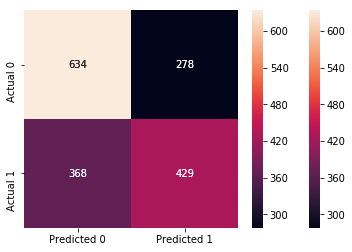

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
y_pred = pipeline.predict(X_test)
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_pred)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  
  table = pd.DataFrame(confusion_matrix(y_true, y_pred), columns = columns, index = index)
  sns.heatmap(table, annot=True, fmt = 'd')
  return sns.heatmap(table, annot=True, fmt = 'd')

plot_confusion_matrix(y_test, y_pred)

### Calculate accuracy 

In [79]:
accuracy = (634 + 429) / (634 + 278 + 368 + 429)
accuracy

0.6220011702750147

### Calculate precision

In [83]:
precision = 634 / (634 + 278)
precision

0.6951754385964912

### Calculate recall

In [82]:
recall = 634 / (634 + 368)
recall

0.6327345309381237